In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

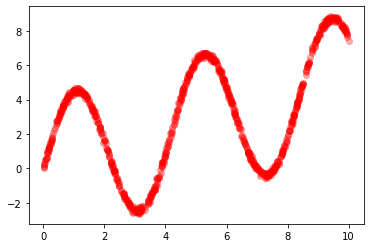

In [114]:
m = 1000
noise_std = 0.1
x_range = 10.0

eps = torch.randn(m, 1) * noise_std
X = torch.rand(m, 1) * x_range
y = 0.5 * X + 4.0 * torch.sin(1.5 * X) + eps


plt.plot(X.squeeze(), y, "ro", alpha=0.3)
plt.show()

In [129]:
# A simple NN as described in PRML
class Net(nn.Module):
    def __init__(self, hidden_dim=100):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)
            
        torch.nn.init.normal_(self.fc1.weight)
        torch.nn.init.normal_(self.fc2.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x

Iteration 0, Loss: 10.296098709106445
Iteration 100, Loss: 5.732953071594238
Iteration 200, Loss: 4.726483345031738
Iteration 300, Loss: 3.895779848098755
Iteration 400, Loss: 0.5032914280891418
Iteration 500, Loss: 0.08459144085645676
Iteration 600, Loss: 0.07323966175317764
Iteration 700, Loss: 0.048933129757642746
Iteration 800, Loss: 0.04277908802032471
Iteration 900, Loss: 0.039772603660821915


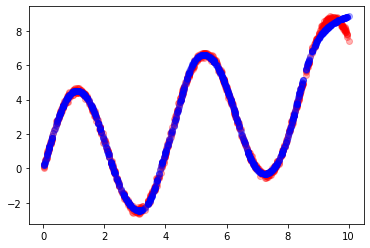

In [130]:
epochs = 1000
lr = 0.1

model = Net()
l2_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(epochs):
    y_hat = model(X)
    loss = l2_loss(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')
        
y_hat = model(X)
plt.plot(X.squeeze(), y,'ro', X.squeeze(), y_hat.squeeze().detach().cpu(), 'bo', alpha=0.3)
plt.show()

Iteration 0, Loss: 436.5368957519531
Iteration 100, Loss: 5.284520626068115
Iteration 200, Loss: 4.984554767608643
Iteration 300, Loss: 4.943236827850342
Iteration 400, Loss: 4.907084941864014
Iteration 500, Loss: 4.8724365234375
Iteration 600, Loss: 4.842734336853027
Iteration 700, Loss: 4.814676284790039
Iteration 800, Loss: 4.783356666564941
Iteration 900, Loss: 4.74708366394043


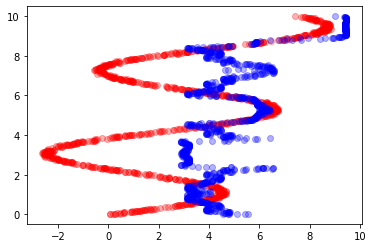

In [131]:
model = Net()
l2_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Again but now inversing the dynamics
for i in range(epochs):
    y_hat = model(y)
    loss = l2_loss(y_hat, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')
        
y_hat = model(y)
plt.plot(y, X.squeeze(),'ro', y_hat.squeeze().detach().cpu(), X.squeeze(), 'bo', alpha=0.3)
plt.show()

Due to multimodality of the data, we cannot get a good fit when using MSE loss it will regress to find good mean values for each of the inputs around 4. Or how PRML describes it, "We see that this leads to a very poor model for the highly non-Gaussian inverse problem".

> We therefore seek a general framework for modelling conditional probability distributions. This can be achieved by using a mixture model for p(t|x) in which both the mixing coefficients as well as the component densities are flexible functions of the input vector x, giving rise to the mixture density network.